In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections

### Instacart dataset description
`orders` (3.4m rows, 206k users):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`deptartments` (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)
* `"test"`: test data reserved for machine learning competitions (~75k orders)

In [2]:
aisles_path='Data/instacart_2017_05_01/aisles.csv'
dep_path='Data/instacart_2017_05_01/departments.csv'
orders_path='Data/instacart_2017_05_01/orders.csv'
products_path='Data/instacart_2017_05_01/products.csv'
o_ppath='Data/instacart_2017_05_01/order_products__prior.csv'

In [3]:
aisles=pd.read_csv(aisles_path)
dep=pd.read_csv(dep_path)
orders=pd.read_csv(orders_path)
products=pd.read_csv(products_path)
oprior=pd.read_csv(o_ppath)

In [70]:
products.product_id.is_unique

True

In [71]:
orders.order_id.is_unique

True

In [75]:
products=products.set_index('product_id')

In [7]:
print(oprior.shape)
oprior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


**Aggregate and save prior orders**

Better to load the data the aggregation takes time

In [8]:
oprior_agg=oprior.groupby('order_id').agg(list)

In [9]:
oprior_agg.head()

,product_id,add_to_cart_order,reordered
order_id,,,
2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014...","[1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 1, 0, 1, 0, 1, 1, 1, 0]"
3,"[33754, 24838, 17704, 21903, 17668, 46667, 174...","[1, 2, 3, 4, 5, 6, 7, 8]","[1, 1, 1, 1, 1, 1, 1, 1]"
4,"[46842, 26434, 39758, 27761, 10054, 21351, 225...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
5,"[13176, 15005, 47329, 27966, 23909, 48370, 132...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6,"[40462, 15873, 41897]","[1, 2, 3]","[0, 0, 0]"


In [11]:
oprior_agg.to_pickle('Data/instacart_2017_05_01/oprior_agg.pkl')

**Load the order agregated data**

In [8]:
oprior_agg=pd.read_pickle('Data/instacart_2017_05_01/oprior_agg.pkl')

In [9]:
# query all the products associated with the order_id=6
products.loc[oprior_agg.product_id[6]]

,product_id,product_name,aisle_id,department_id
40462,40463,Organic Roasted Garlic Hummus,67,20
15873,15874,Burnt Caramel Tiles,45,19
41897,41898,Organic Stress Ease Tea,94,7


In [13]:
oprior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [53]:
tmp=oprior.groupby('product_id').count()[['order_id']]
tmp.columns=['n_orders']
products=products.merge(tmp,left_index=True, right_index=True)

In [86]:
products=products.sort_values('n_orders',ascending=False)

In [107]:
products.head(n=2500)

,product_name,aisle_id,department_id,n_orders
product_id,,,,
24852,Banana,24,4,472565
13176,Bag of Organic Bananas,24,4,379450
21137,Organic Strawberries,24,4,264683
21903,Organic Baby Spinach,123,4,241921
47209,Organic Hass Avocado,24,4,213584
...,...,...,...,...
43421,"Little Yums Spinach, Apple, and Kale Teething ...",92,18,2275
42579,Organic Pitted Prunes,117,19,2274
27737,Brown Rice Black-Eyed Peas and Veggies Bowl,38,1,2272


In [110]:
products.quantile(0.95) #only 5% of the products have more than 2286 orders we can focus on those products

aisle_id          126.0
department_id      20.0
n_orders         2286.0
Name: 0.95, dtype: float64

In [111]:
prod_95=products[products['n_orders']>=products.quantile(0.95)['n_orders']].copy()

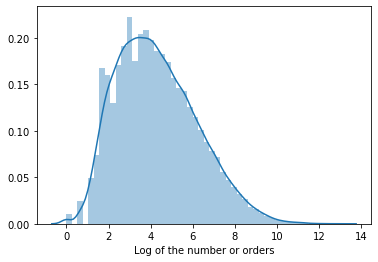

In [100]:
sns.distplot(np.log(products['n_orders'].values))
plt.xlabel('Log of the number or orders')
plt.show()

In [114]:
prod_95.head()

,product_name,aisle_id,department_id,n_orders
product_id,,,,
24852,Banana,24,4,472565
13176,Bag of Organic Bananas,24,4,379450
21137,Organic Strawberries,24,4,264683
21903,Organic Baby Spinach,123,4,241921
47209,Organic Hass Avocado,24,4,213584
